Using GPU : Quadro RTX 8000 (ID 0)


/state/partition1/job-64486977/ipykernel_2237617/583675547.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")
/state/partition

Loaded: ANN-X, ANN-ΔX, LSTM-X(q=5), LSTM-ΔX(q=15)

Running scenario: Numerical vs Numerical


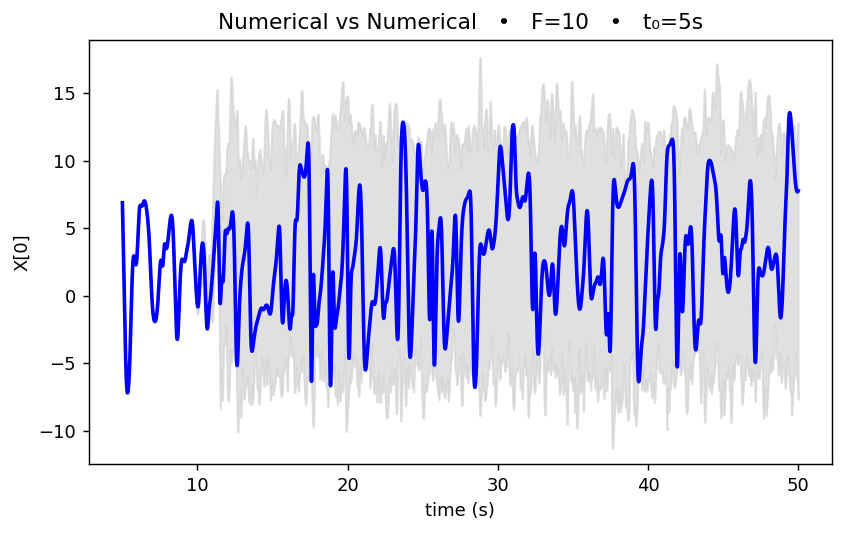


Running scenario: ANN-X vs Numerical


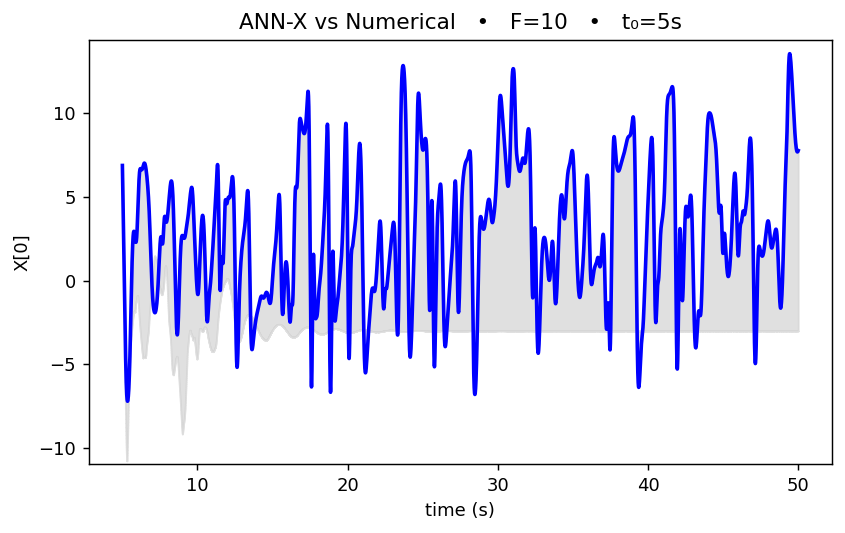


Running scenario: LSTM-X vs Numerical


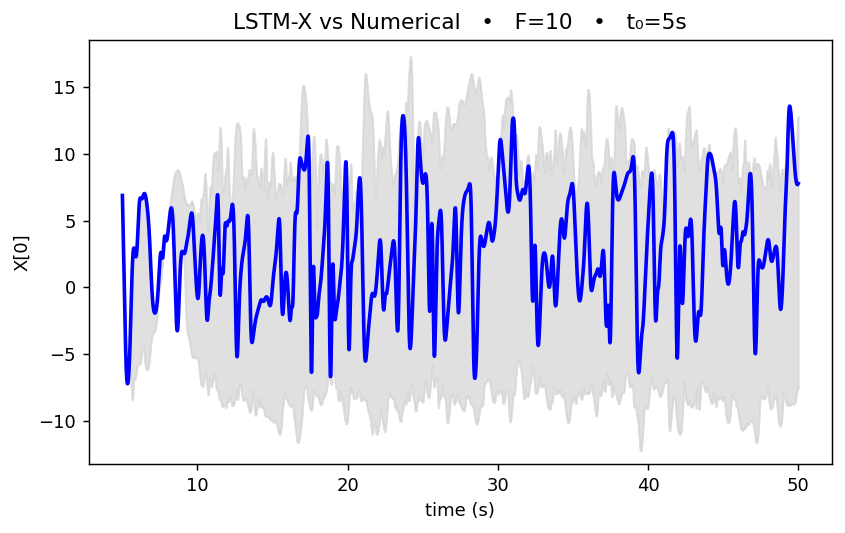


Running scenario: ANN-X vs ANN-X


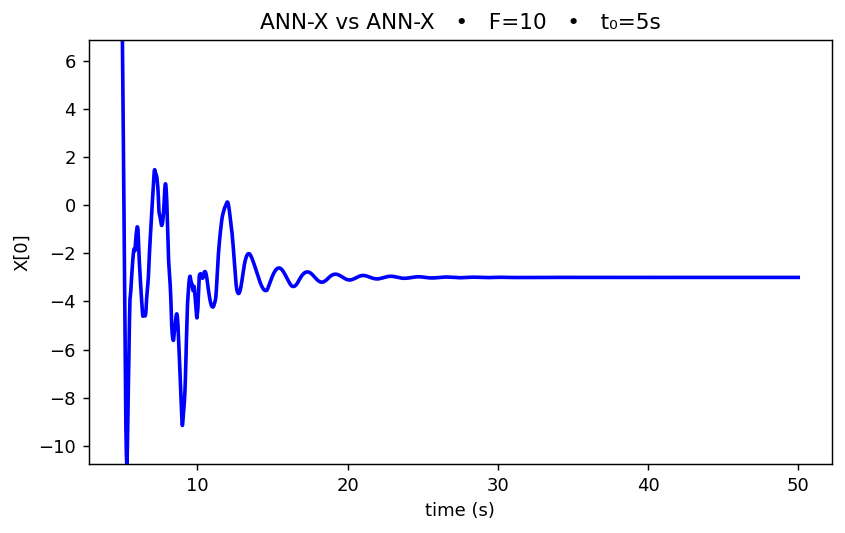


Running scenario: LSTM-X vs LSTM-X


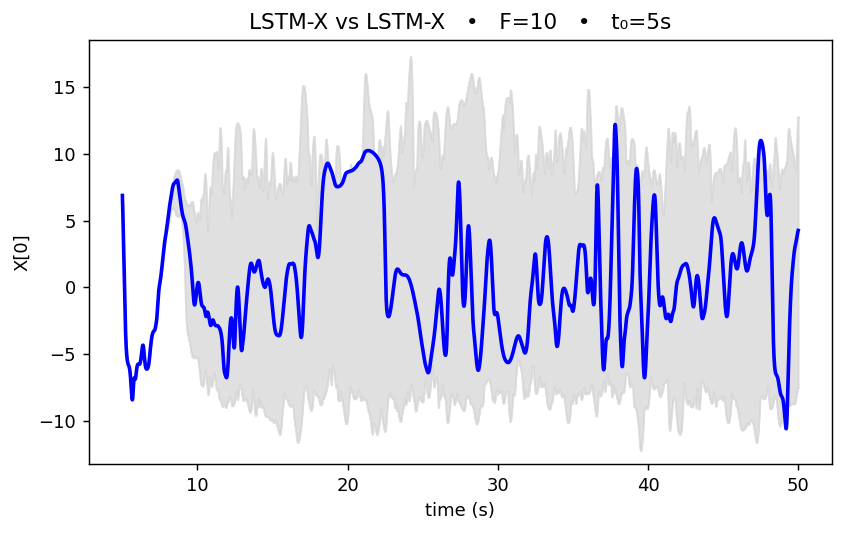


Running scenario: ANN-ΔX + AB3 vs Numerical


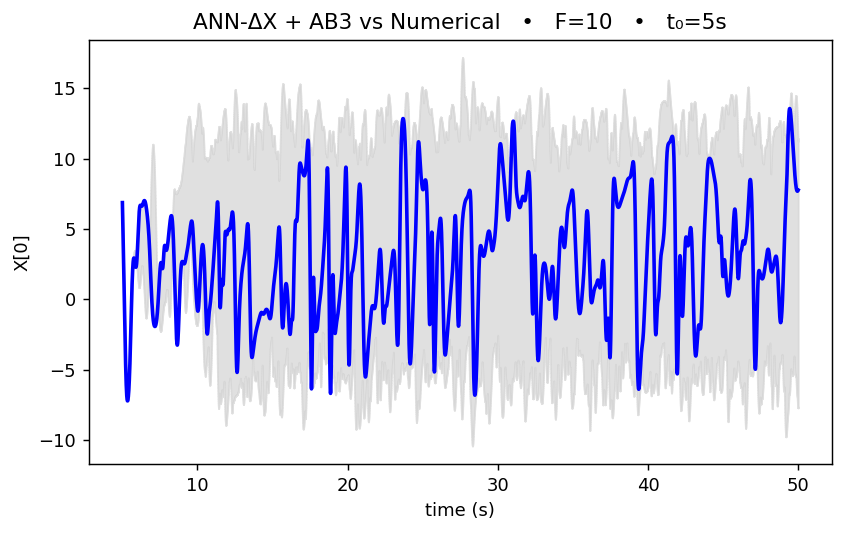


Running scenario: LSTM-ΔX + AB3 vs Numerical


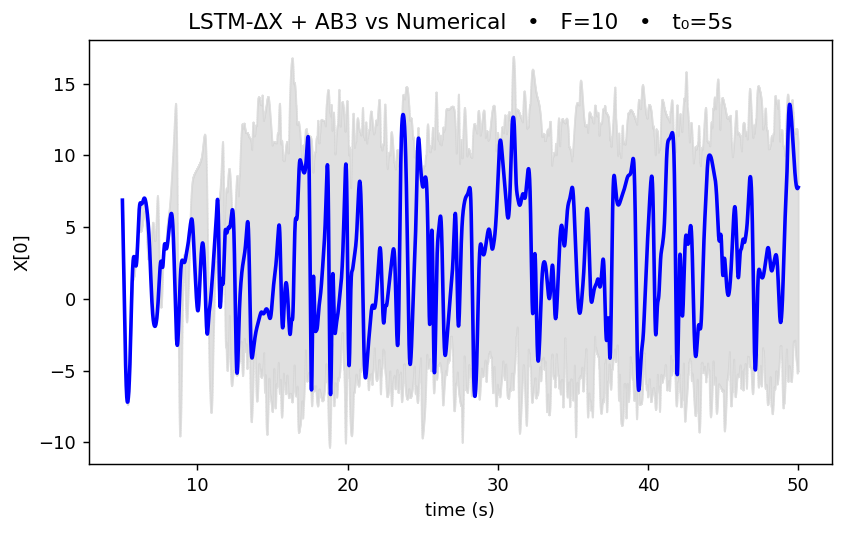


Running scenario: ANN-ΔX + AB3 vs ANN-ΔX + AB3


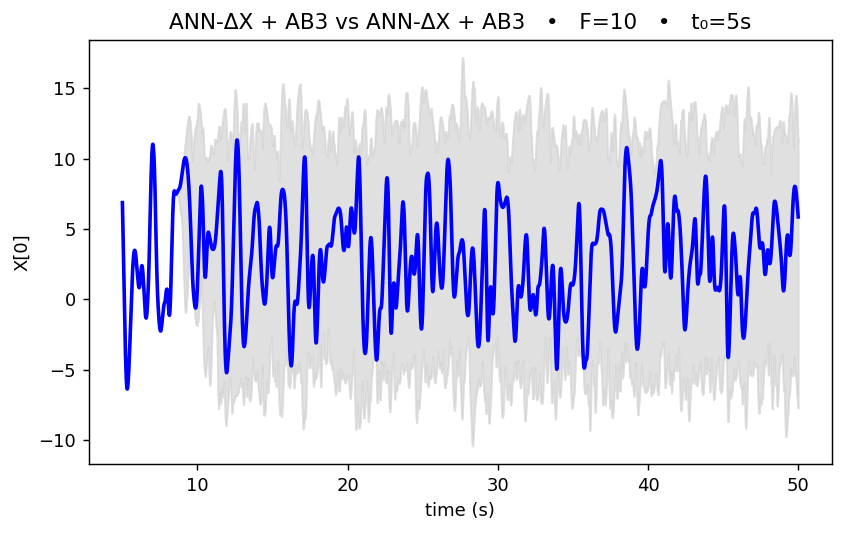


Running scenario: LSTM-ΔX + AB3 vs LSTM-ΔX + AB3


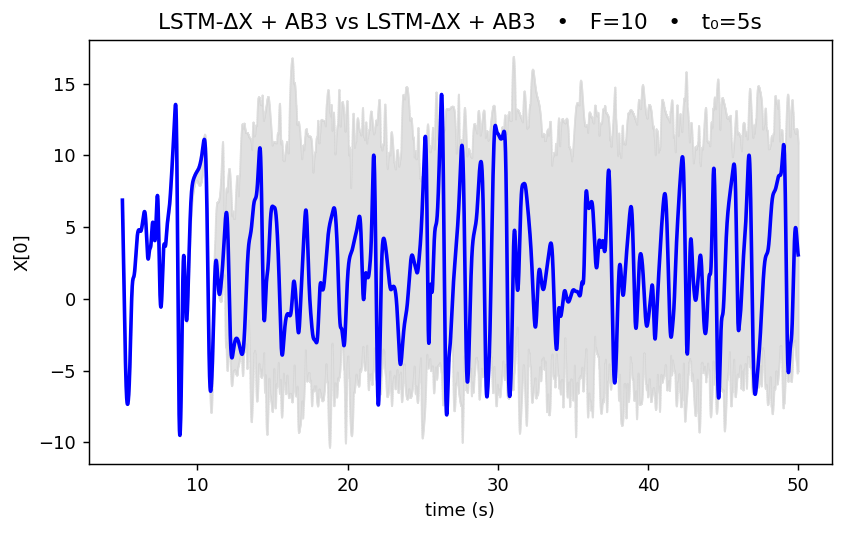


All scenarios completed.


In [1]:
#!/usr/bin/env python3
# =============================================================================
#  Divergence study • NUM vs NUM, X-models (no AB), ΔX-models (+ AB-3 in z)
#  Single script, parameter-driven (easily switch F = 5 / 10 / 15)
# =============================================================================
import os, re, math, copy, warnings
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)  # silence harmless jit/pickle messages
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── USER CONFIG ─────────────────────────────
# Change these 7 items to swap between F = 5 / 10 / 15 runs.
F_FORCE        = 10.0                       # ← 5.0 / 10.0 / 15.0
DATA_FILE      = "force_10_data.npz"        # training set (for μ/σ fallback)
SHIFTED_FILE   = "shifted_force10_data.npz" # unseen/shifted trajectories (centre & history)

CKPT_ANN_X     = "standard_early_stopping_force10_annX.pt"         # ANN-X (next-state)
CKPT_ANN_dX    = "standard_early_stopping_force10_ann.pt"          # ANN-ΔX (delta)
CKPT_LSTM_X    = "standard_early_stopping_force10_LSTM_H70_q5.pt"  # LSTM-X (next-state)
CKPT_LSTM_dX   = "standard_early_stopping_force10_LSTM_dX_H70_q15.pt" # LSTM-ΔX (delta)

# If an LSTM checkpoint lacks lookback and filename lacks “_q{q}”, set an integer override:
Q_OVERRIDE_LSTM_X  = None
Q_OVERRIDE_LSTM_dX = None

# Time, ensemble, plotting
DT, T0, T_END = 0.005, 5.0, 50.0
K, EPS        = 50, 1e-5
RADIUS        = EPS * math.sqrt(5/3)       # RMS(perturbation) = ε
CENTRE_TRAJ_INDEX = 0                      # choose which shifted traj provides the centre/history

# Optional envelope clipping for ANN-X scenarios (as in your old code parts 2 & 4)
ANNX_Y_CLIP   = None     # set to None to disable clipping; default 10.0
RANDOM_SEED   = 0        # perturbation seed
# ─────────────────────────────────────────────────────────────────────

# ───────── Device ─────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count()))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)

# ───────── Time indexing ─────────
steps_per_s = int(round(1/DT))
i0          = int(round(T0   * steps_per_s))          # index at t0
i_end       = int(round(T_END * steps_per_s))         # index at T_END
assert i_end > i0, "T_END must be > T0."
N_STEPS_SIM = i_end - i0                              # number of steps simulated
t_axis      = np.arange(N_STEPS_SIM + 1, dtype=np.float32) * DT + T0

# ───────── Load datasets ─────────
X_train_all  = np.load(DATA_FILE)["X"].astype(np.float32)      # (traj, step, 36)
X_shift_all  = np.load(SHIFTED_FILE)["X"].astype(np.float32)   # (traj, step, 36)
_, _, N = X_shift_all.shape

# μ/σ fallback (global, from training set)
MU_FALL = torch.from_numpy(X_train_all.reshape(-1, N).mean(0)).float().to(DEVICE)
SD_FALL = torch.from_numpy(X_train_all.reshape(-1, N).std (0) + 1e-8).float().to(DEVICE)

# ───────── L96 (Torch) ─────────
def l96_rhs_torch(x, F=F_FORCE):
    # x shape (..., 36); broadcast on last dim
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step_torch(x, dt=DT):
    k1 = l96_rhs_torch(x)
    k2 = l96_rhs_torch(x + 0.5*dt*k1)
    k3 = l96_rhs_torch(x + 0.5*dt*k2)
    k4 = l96_rhs_torch(x + dt * k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

# ───────── Helpers: robust state-dict & q detection ─────────
def _parse_q_from_name(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        # direct state dict? (all tensors)
        if all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None:
                    return sd
    return None

# ───────── Model builders ─────────
def make_mlp(sizes=(36,128,128,64,36), act="relu"):
    acts = dict(relu=nn.ReLU, tanh=nn.Tanh, gelu=nn.GELU)
    layers=[]
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

class LSTMHead(nn.Module):
    """1-layer LSTM + Linear head → output dimension N."""
    def __init__(self, n=36, hidden=70):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):             # w: (B, q, N)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])    # (B, N)

# ───────── Load checkpoints & assemble nets ─────────
def load_ann_x(path):
    ckpt = torch.load(path, map_location="cpu")
    net  = make_mlp().to(DEVICE).eval()
    sd   = ckpt["net"] if isinstance(ckpt, dict) and "net" in ckpt else _find_state_dict(ckpt)
    if sd is None: raise RuntimeError(f"ANN-X: no state_dict in {path}")
    net.load_state_dict(sd)
    mu = torch.from_numpy(np.asarray(ckpt.get("mean", MU_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    sd = torch.from_numpy(np.asarray(ckpt.get("std" , SD_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    return net, mu, sd

def load_ann_dx(path):
    ckpt = torch.load(path, map_location="cpu")
    net  = make_mlp().to(DEVICE).eval()
    sdct = ckpt["net"] if isinstance(ckpt, dict) and "net" in ckpt else _find_state_dict(ckpt)
    if sdct is None: raise RuntimeError(f"ANN-ΔX: no state_dict in {path}")
    net.load_state_dict(sdct)
    mu = torch.from_numpy(np.asarray(ckpt.get("mean", MU_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    sd = torch.from_numpy(np.asarray(ckpt.get("std" , SD_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    return net, mu, sd

def load_lstm_x(path):
    ckpt = torch.load(path, map_location="cpu")
    state_dict = ckpt["net"] if isinstance(ckpt, dict) and "net" in ckpt else _find_state_dict(ckpt)
    if state_dict is None: raise RuntimeError(f"LSTM-X: no state_dict in {path}")
    q = None
    if isinstance(ckpt, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ckpt and ckpt[k] is not None:
                q = int(ckpt[k]); break
    if q is None: q = _parse_q_from_name(path)
    if q is None and Q_OVERRIDE_LSTM_X is not None:
        q = int(Q_OVERRIDE_LSTM_X)
    if q is None:
        raise ValueError(f"LSTM-X lookback not found. Set Q_OVERRIDE_LSTM_X.")
    hidden = int(ckpt.get("hidden_size", 70)) if isinstance(ckpt, dict) else 70
    net = LSTMHead(n=N, hidden=hidden).to(DEVICE).eval()
    net.load_state_dict(state_dict)
    mu = torch.from_numpy(np.asarray(ckpt.get("mean", MU_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    sd = torch.from_numpy(np.asarray(ckpt.get("std" , SD_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    return net, mu, sd, q

def load_lstm_dx(path):
    ckpt = torch.load(path, map_location="cpu")
    state_dict = ckpt["net"] if isinstance(ckpt, dict) and "net" in ckpt else _find_state_dict(ckpt)
    if state_dict is None: raise RuntimeError(f"LSTM-ΔX: no state_dict in {path}")
    q = None
    if isinstance(ckpt, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ckpt and ckpt[k] is not None:
                q = int(ckpt[k]); break
    if q is None: q = _parse_q_from_name(path)
    if q is None and Q_OVERRIDE_LSTM_dX is not None:
        q = int(Q_OVERRIDE_LSTM_dX)
    if q is None:
        raise ValueError(f"LSTM-ΔX lookback not found. Set Q_OVERRIDE_LSTM_dX.")
    hidden = int(ckpt.get("hidden_size", 70)) if isinstance(ckpt, dict) else 70
    net = LSTMHead(n=N, hidden=hidden).to(DEVICE).eval()
    net.load_state_dict(state_dict)
    mu = torch.from_numpy(np.asarray(ckpt.get("mean", MU_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    sd = torch.from_numpy(np.asarray(ckpt.get("std" , SD_FALL.cpu().numpy()), dtype=np.float32)).to(DEVICE)
    return net, mu, sd, q

# ───────── Centre, ensemble & history at t0 ─────────
centre_traj_np = X_shift_all[CENTRE_TRAJ_INDEX]       # (steps, 36) – unseen/shifted
x0_center_np   = centre_traj_np[i0].astype(np.float32)
rng = np.random.default_rng(RANDOM_SEED)
ensemble0_np = x0_center_np + RADIUS * rng.standard_normal((K, N)).astype(np.float32)  # (K, N)

def get_centre_history(q: int) -> np.ndarray:
    """Return centre history frames (q-1, N) just before t0, in physical units."""
    if q <= 1:
        return np.zeros((0, N), dtype=np.float32)
    hist = centre_traj_np[i0 - q + 1 : i0].astype(np.float32)
    if hist.shape[0] != q - 1:
        raise RuntimeError("Not enough history before t0 for requested q.")
    return hist

# ───────── Roll-out helpers (vectorised when useful) ─────────
@torch.no_grad()
def rollout_num(x0_np: np.ndarray, steps: int) -> np.ndarray:
    out = np.empty((steps+1, N), np.float32)
    x   = torch.from_numpy(x0_np).float().to(DEVICE)
    out[0] = x0_np
    for s in range(steps):
        x = rk4_step_torch(x)
        out[s+1] = x.detach().cpu().numpy()
    return out

@torch.no_grad()
def rollout_ann_x(x0_np: np.ndarray, steps: int, net, mu_t, sd_t) -> np.ndarray:
    """
    ANN-X: direct next-state in z-space (no AB).  x_next_norm = net(x_norm).
    """
    out = np.empty((steps+1, N), np.float32)
    xz  = (torch.from_numpy(x0_np).float().to(DEVICE) - mu_t)/sd_t
    out[0] = x0_np
    for s in range(steps):
        xz = net(xz.unsqueeze(0)).squeeze(0)               # next state (z)
        out[s+1] = (xz*sd_t + mu_t).detach().cpu().numpy()
    return out

@torch.no_grad()
def rollout_lstm_x(x0_np: np.ndarray, steps: int, net, mu_t, sd_t, q: int,
                   centre_hist_np: np.ndarray) -> np.ndarray:
    """
    LSTM-X: next-state in z-space, with **centre-history seeding**.
    Window per member: [centre_hist (q-1), x0_member].
    """
    out = np.empty((steps+1, N), np.float32)
    out[0] = x0_np
    if q <= 1:
        win = ((torch.from_numpy(x0_np).float().to(DEVICE) - mu_t)/sd_t)[None, None, :]  # (1,1,N)
    else:
        win_phys = np.vstack([centre_hist_np, x0_np]).astype(np.float32)                 # (q,N)
        win = ((torch.from_numpy(win_phys).float().to(DEVICE) - mu_t)/sd_t)[None, :, :]  # (1,q,N)
    for s in range(steps):
        x_next_norm = net(win)                      # (1,N)
        x_next_phys = (x_next_norm*sd_t + mu_t).squeeze(0)
        out[s+1]    = x_next_phys.detach().cpu().numpy()
        # slide
        win = torch.cat([win[:, 1:, :], x_next_norm[:, None, :]], dim=1) if q>1 else x_next_norm[:, None, :]
    return out

def _ab3(step_now, prev1, prev2):
    if prev1 is None:      return step_now
    if prev2 is None:      return 1.5*step_now - 0.5*prev1
    return (23/12)*step_now - (4/3)*prev1 + (5/12)*prev2

@torch.no_grad()
def rollout_ann_dx(x0_np: np.ndarray, steps: int, net, mu_t, sd_t) -> np.ndarray:
    """
    ANN-ΔX: AB-3 in z-space on ΔX̂.
    """
    out = np.empty((steps+1, N), np.float32)
    out[0] = x0_np
    xz     = (torch.from_numpy(x0_np).float().to(DEVICE) - mu_t)/sd_t   # (N,)
    d1 = d2 = None
    for s in range(steps):
        dx1   = net(xz.unsqueeze(0)).squeeze(0)     # (N,)  ΔX̂
        stepz = _ab3(dx1, d1, d2)
        xz    = xz + stepz
        out[s+1] = (xz*sd_t + mu_t).detach().cpu().numpy()
        d2, d1 = d1, dx1
    return out

@torch.no_grad()
def rollout_lstm_dx(x0_np: np.ndarray, steps: int, net, mu_t, sd_t, q: int,
                    centre_hist_np: np.ndarray) -> np.ndarray:
    """
    LSTM-ΔX: AB-3 in z-space, **centre-history seeding** for the window.
    Window per member: [centre_hist (q-1), x0_member]  (all in z).
    """
    out = np.empty((steps+1, N), np.float32)
    out[0] = x0_np
    if q <= 1:
        win = ((torch.from_numpy(x0_np).float().to(DEVICE) - mu_t)/sd_t)[None, None, :]  # (1,1,N)
    else:
        win_phys = np.vstack([centre_hist_np, x0_np]).astype(np.float32)
        win = ((torch.from_numpy(win_phys).float().to(DEVICE) - mu_t)/sd_t)[None, :, :]   # (1,q,N)
    d1 = d2 = None
    for s in range(steps):
        dx1   = net(win)                            # (1,N)
        stepz = _ab3(dx1, d1, d2)                   # broadcasting OK (1,N) vs None/Tensors
        new_z = win[:, -1, :] + stepz               # (1,N)
        out[s+1] = (new_z*sd_t + mu_t).squeeze(0).detach().cpu().numpy()
        # slide window with the updated last frame
        win = torch.cat([win[:, 1:, :], new_z[:, None, :]], dim=1) if q>1 else new_z[:, None, :]
        d2, d1 = d1, dx1
    return out

# ───────── Load all nets (+ μ/σ, q where applicable) ─────────
ann_x,  mu_ax, sd_ax   = load_ann_x (CKPT_ANN_X)
ann_dx, mu_ad, sd_ad   = load_ann_dx(CKPT_ANN_dX)
lstm_x, mu_lx, sd_lx, q_lx = load_lstm_x (CKPT_LSTM_X)
lstm_dx,mu_ld, sd_ld, q_ld = load_lstm_dx(CKPT_LSTM_dX)

print(f"Loaded: ANN-X, ANN-ΔX, LSTM-X(q={q_lx}), LSTM-ΔX(q={q_ld})")

# precompute centre history (physical) for sequence models
centre_hist_lx  = get_centre_history(q_lx)
centre_hist_ldx = get_centre_history(q_ld)

# ───────── Scenario registry ─────────
# name, centre_f, ensemble_f, clip_y (None or float)
SCENARIOS = [
    # Part 1
    ("Numerical vs Numerical",
     lambda x0, n: rollout_num(x0, n),
     lambda x0, n: rollout_num(x0, n),
     None),

    # Parts 2–5 (X-models, no AB)
    ("ANN-X vs Numerical",
     lambda x0, n: rollout_num(x0, n),
     lambda x0, n: rollout_ann_x(x0, n, ann_x, mu_ax, sd_ax),
     ANNX_Y_CLIP),

    ("LSTM-X vs Numerical",
     lambda x0, n: rollout_num(x0, n),
     lambda x0, n: rollout_lstm_x(x0, n, lstm_x, mu_lx, sd_lx, q_lx, centre_hist_lx),
     None),

    ("ANN-X vs ANN-X",
     lambda x0, n: rollout_ann_x(x0, n, ann_x, mu_ax, sd_ax),
     lambda x0, n: rollout_ann_x(x0, n, ann_x, mu_ax, sd_ax),
     ANNX_Y_CLIP),

    ("LSTM-X vs LSTM-X",
     lambda x0, n: rollout_lstm_x(x0, n, lstm_x, mu_lx, sd_lx, q_lx, centre_hist_lx),
     lambda x0, n: rollout_lstm_x(x0, n, lstm_x, mu_lx, sd_lx, q_lx, centre_hist_lx),
     None),

    # Parts 6–9 (ΔX-models, AB-3)
    ("ANN-ΔX + AB3 vs Numerical",
     lambda x0, n: rollout_num(x0, n),
     lambda x0, n: rollout_ann_dx(x0, n, ann_dx, mu_ad, sd_ad),
     None),

    ("LSTM-ΔX + AB3 vs Numerical",
     lambda x0, n: rollout_num(x0, n),
     lambda x0, n: rollout_lstm_dx(x0, n, lstm_dx, mu_ld, sd_ld, q_ld, centre_hist_ldx),
     None),

    ("ANN-ΔX + AB3 vs ANN-ΔX + AB3",
     lambda x0, n: rollout_ann_dx(x0, n, ann_dx, mu_ad, sd_ad),
     lambda x0, n: rollout_ann_dx(x0, n, ann_dx, mu_ad, sd_ad),
     None),

    ("LSTM-ΔX + AB3 vs LSTM-ΔX + AB3",
     lambda x0, n: rollout_lstm_dx(x0, n, lstm_dx, mu_ld, sd_ld, q_ld, centre_hist_ldx),
     lambda x0, n: rollout_lstm_dx(x0, n, lstm_dx, mu_ld, sd_ld, q_ld, centre_hist_ldx),
     None),
]

# ───────── Plot helper (envelope + adaptive/optional clipping) ─────────
def plot_envelope(title, center_traj: np.ndarray, ens_trajs: np.ndarray,
                  clip_y: float | None, y_index: int = 0):
    """
    centre_traj : (T+1, N)
    ens_trajs   : (K, T+1, N)
    """
    all_stack = np.concatenate([center_traj[None, ...], ens_trajs], axis=0)  # (K+1, T+1, N)
    y_min = np.nanmin(all_stack[:, :, y_index], axis=0)
    y_max = np.nanmax(all_stack[:, :, y_index], axis=0)

    if clip_y is not None:
        overflow = (y_max >  clip_y) | (y_min < -clip_y)
        lo = np.clip(y_min, -clip_y, clip_y)
        hi = np.clip(y_max, -clip_y, clip_y)
        y_lo, y_hi = -clip_y, clip_y
    else:
        overflow = np.zeros_like(y_min, dtype=bool)
        # small margin
        pad = 0.05*(y_max - y_min + 1e-6)
        y_lo = float((y_min - pad).min())
        y_hi = float((y_max + pad).max())
        lo, hi = y_min, y_max

    plt.figure(figsize=(6.6, 4.2), dpi=130)
    # normal envelope
    plt.fill_between(t_axis, lo, hi, where=~overflow, color="lightgrey", alpha=0.7, step="mid")
    # overflow columns (only when clipping)
    if clip_y is not None and overflow.any():
        plt.fill_between(t_axis, -clip_y, clip_y, where=overflow,
                         color="lightgrey", alpha=0.9, step="mid")
        max_over = np.nanmax(np.abs([y_min[overflow], y_max[overflow]]))
        plt.text(0.98, 0.02, f"|X[{y_index}]| exceeded {clip_y:g}\nmax≈{max_over:.1e}",
                 transform=plt.gca().transAxes, ha="right", va="bottom",
                 fontsize=8, color="dimgray")

    plt.plot(t_axis, center_traj[:, y_index], lw=2.0, color="blue", label="centre")
    plt.xlabel("time (s)"); plt.ylabel(f"X[{y_index}]")
    plt.ylim(y_lo, y_hi)
    plt.title(title + f"   •   F={int(F_FORCE)}   •   t₀={T0:g}s")
    plt.tight_layout(); plt.show()

# ───────── Run all scenarios ─────────
for title, f_center, f_member, clip_y in SCENARIOS:
    print(f"\nRunning scenario: {title}")
    # centre rollout
    centre_traj = f_center(x0_center_np.copy(), N_STEPS_SIM)          # (T+1, N)
    # ensemble rollouts
    ens_trajs   = np.stack([f_member(e.copy(), N_STEPS_SIM) for e in ensemble0_np], axis=0)  # (K, T+1, N)
    # plot for component 0 (as in your examples)
    plot_envelope(title, centre_traj, ens_trajs, clip_y, y_index=0)

print("\nAll scenarios completed.")
